# Lending Club Case Study

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
from warnings import filterwarnings

In [9]:
filterwarnings("ignore")

#supress scientific notation of values
pd.options.display.float_format = '{:.2f}'.format

Custom functions

In [10]:
def remove_perc(val):
    try:
        val = val.replace("%","")
        return val
    except AttributeError:
        new_val = val
        return new_val


---

In [11]:
master = pd.read_csv("loan.csv")
#Finding percentage of null or missing values
null_perc = round(100*(master.isnull().sum()/len(master.index)), 2)
#Printing columns which have more than 0% missing values
null_perc[ null_perc > 0 ]

emp_title                      6.19
emp_length                     2.71
desc                          32.58
title                          0.03
mths_since_last_delinq        64.66
                              ...  
tax_liens                      0.10
tot_hi_cred_lim              100.00
total_bal_ex_mort            100.00
total_bc_limit               100.00
total_il_high_credit_limit   100.00
Length: 68, dtype: float64

As it can be seen that there are many columns, that have null values. Thus, I have run a separate analysis which resulted in the following columns being the only relevant features:

The features are only used after the loan has been approved and then the applicants are kept under monitoring.

List of post-approval features: <br>
- delinq_2yrs
- revol_bal
- out_prncp
- total_pymnt
- total_rec_prncp
- total_rec_int
- total_rec_late_fee
- recoveries
- collection_recovery_fee
- last_pymnt_d
- last_pymnt_amnt
- next_pymnt_d
- chargeoff_within_12_mths
- mths_since_last_delinq
- mths_since_last_record


In [12]:
cols_use = ["loan_amnt","funded_amnt","funded_amnt_inv","term","int_rate","installment","grade","sub_grade",
"emp_title","emp_length","home_ownership","annual_inc","verification_status","issue_d","loan_status","pymnt_plan",
"desc","purpose","title","addr_state","dti","earliest_cr_line","delinq_2yrs","earliest_cr_line","inq_last_6mths",
"mths_since_last_delinq","mths_since_last_record","open_acc","pub_rec","revol_bal","revol_util","total_acc","initial_list_status",
"out_prncp","out_prncp_inv","total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee",
"recoveries","collection_recovery_fee","last_pymnt_d","last_pymnt_amnt","next_pymnt_d","last_credit_pull_d",
"collections_12_mths_ex_med","mths_since_last_major_derog","policy_code","application_type"]

In [13]:
master = pd.read_csv("loan.csv",usecols=cols_use)
master.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,5000,5000,4975.00,36 months,10.65%,162.87,B,B2,NaN,10+ years,...,0.00,0.00,Jan-15,171.62,NaN,May-16,0.00,NaN,1,INDIVIDUAL
1,2500,2500,2500.00,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,...,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.00,NaN,1,INDIVIDUAL
2,2400,2400,2400.00,36 months,15.96%,84.33,C,C5,NaN,10+ years,...,0.00,0.00,Jun-14,649.91,NaN,May-16,0.00,NaN,1,INDIVIDUAL
3,10000,10000,10000.00,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,...,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.00,NaN,1,INDIVIDUAL
4,3000,3000,3000.00,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,...,0.00,0.00,May-16,67.79,Jun-16,May-16,0.00,NaN,1,INDIVIDUAL


In [31]:
charged_off = master[master["loan_status"] == "Charged Off"]
charged_off.shape

(5627, 49)

## Cleaning the dataset:

In [14]:
# Interest rate:
# Removing the percentage sign and converting to float.
master["int_rate"] = master["int_rate"].apply(lambda x: float(x.replace("%","")))

In [15]:
# Replacing the Abbreviation of State with their complete names:
with open("State_abbr.json","r") as f:
    states = load(f)

master["addr_state"] = master["addr_state"].replace(states)


In [16]:
# Revolving Utlity
master["revol_util"] = master["revol_util"].apply(remove_perc)
master["revol_util"] = master["revol_util"].apply(lambda x:float(x))

In [ ]:
## Home Ownership has 3 NONE values, so it is better to combine it with "OTHER" for analysis:
master["home_ownership"] = master["home_ownership"].replace("NONE","OTHER")

## Univariate Analysis

#### Loan Amount

count   39717.00
mean    11219.44
std      7456.67
min       500.00
25%      5500.00
50%     10000.00
75%     15000.00
max     35000.00
Name: loan_amnt, dtype: float64


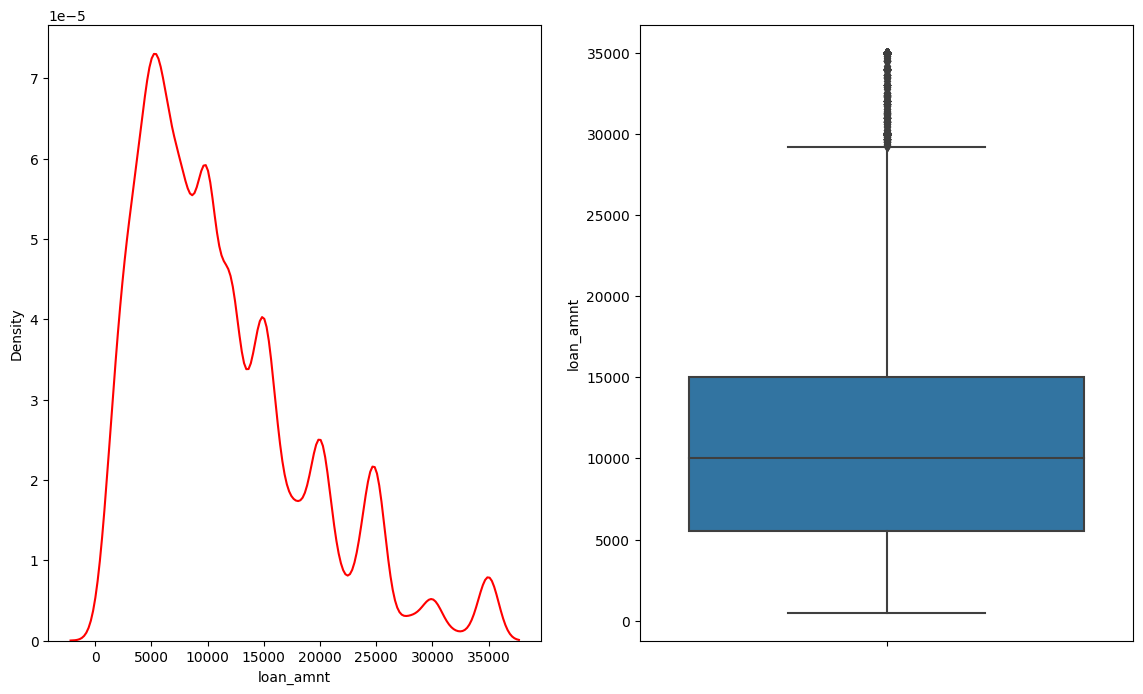

In [24]:
fig, ax = plt.subplots(1,2,figsize=(10,6))
sns.kdeplot(ax=ax[0],x=master["loan_amnt"],color='red');
sns.boxplot(ax=ax[1],y=master["loan_amnt"]);
print(master["loan_amnt"].describe())

It can be seen that majority of the loans that are given are in the range of $5000 to $15000 with only a minor amount of loans going beyond $35000.

---


In [ ]:
# Interest Rate
master['int_rate_groups'] = pd.cut(master['int_rate'], bins=5,precision =0,labels=['5%-9%','9%-13%','13%-17%','17%-21%','21%-24%'])

### Exploring the Categorical Variables

#### Grade and Subgrades
The details of the Grades and Subgrades of the loans can be found here : <br>

https://www.lendingclub.com/foliofn/rateDetail.action <br>

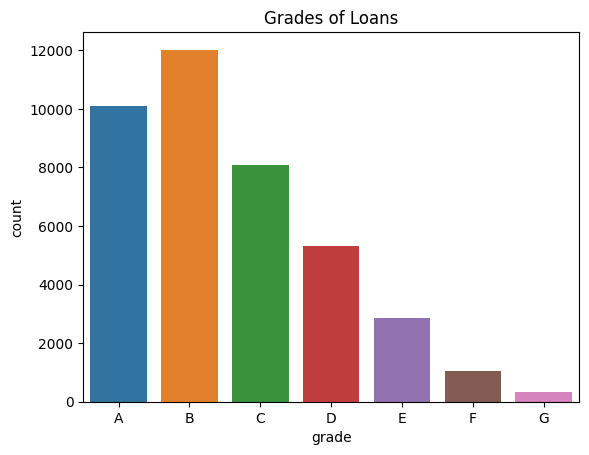

In [27]:
grades = master["grade"]
plt.title("Grades of Loans")
sns.countplot(grades,order=["A","B","C","D","E","F","G"]);

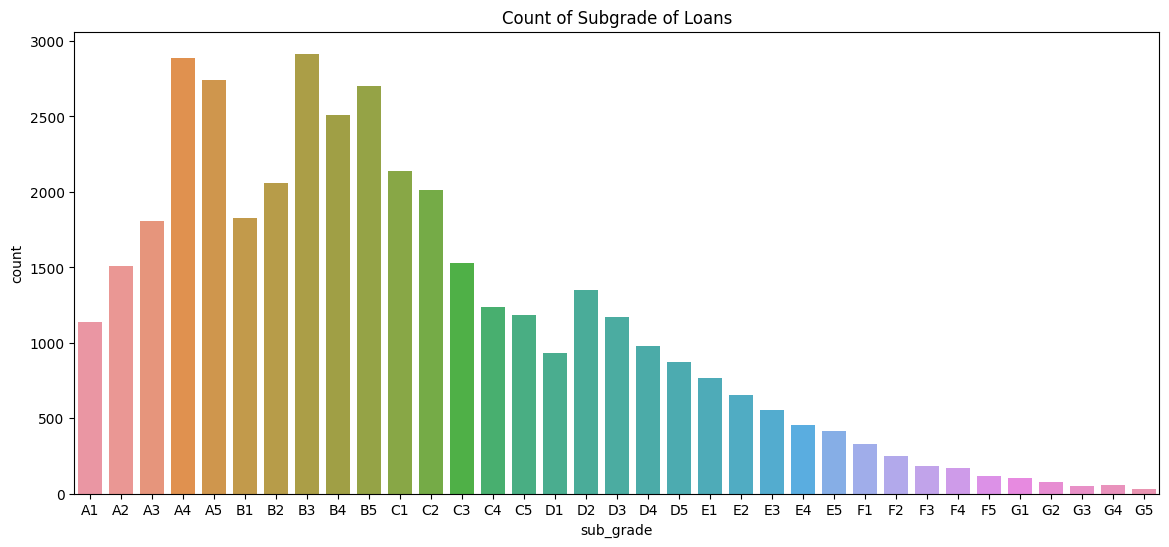

In [28]:
subgrade = master["sub_grade"]
subgrade.value_counts()
order = sorted(subgrade.value_counts().index)
plt.figure(figsize=(14,6))
plt.title("Count of Subgrade of Loans")
sns.countplot(subgrade,order=order);

As per the link above, B grade loans have a interest rate of <b>13.33%</b> to **16.08%** <i>(as of 7th Sep 2022)</i>.

#### Home Ownership:

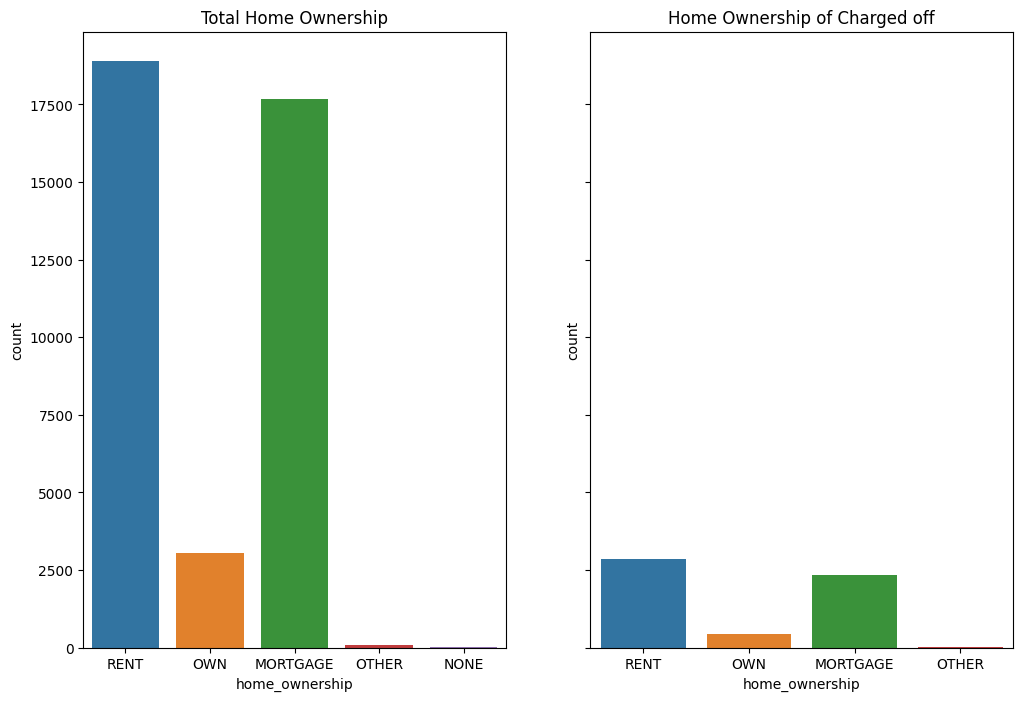

In [45]:
fig, ax = plt.subplots(1,2,figsize=(12,8),sharey=True)
ax[0].set_title("Total Home Ownership")
sns.countplot(ax=ax[0],x=master["home_ownership"]);

ax[1].set_title("Home Ownership of Charged off")
sns.countplot(ax=ax[1],x=charged_off["home_ownership"]);


<h4> Inference </h4>:  <br>
In both the cases, the people who rent and mortgage their homes take a lot of loans. Even amongst the defaulters, the renters and mortgages are the risky ones. 

### Purpose

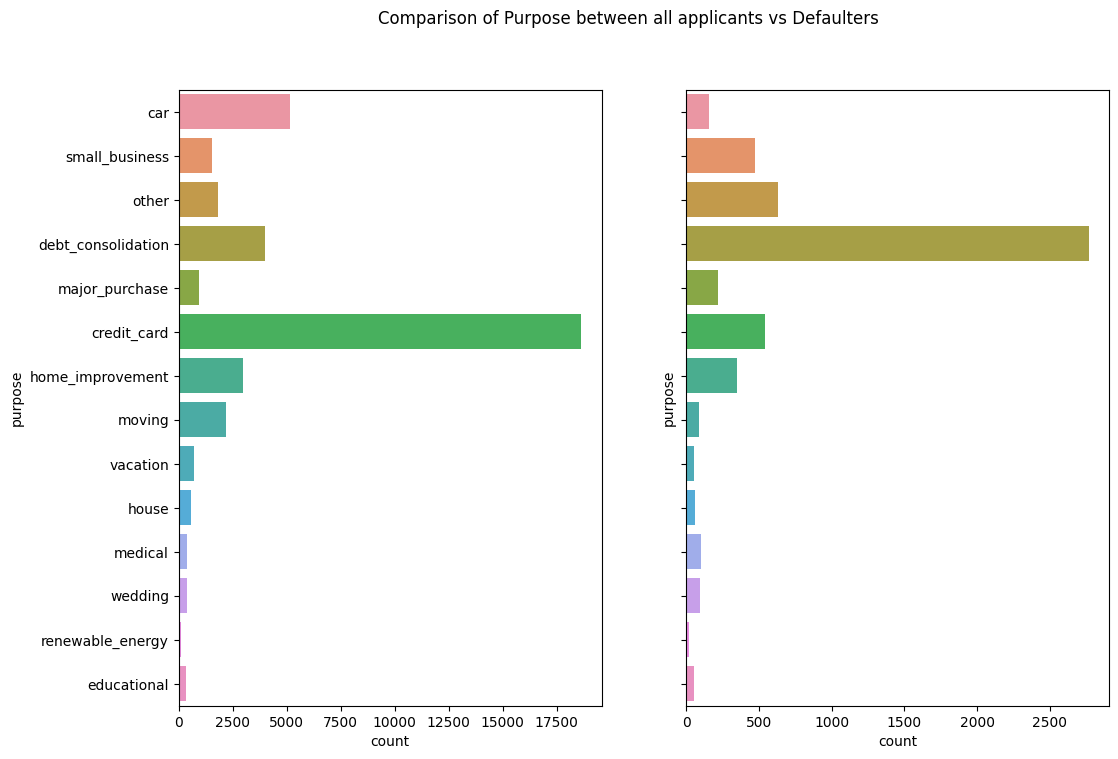

In [50]:
fig, ax = plt.subplots(1,2,figsize = (12,8),sharey=True)
plt.suptitle("Comparison of Purpose between all applicants vs Defaulters")
sns.countplot(ax=ax[0], y ='purpose', data=master)
sns.countplot(ax=ax[1], y ='purpose', data=charged_off)
plt.show();


#### Inference:


States  

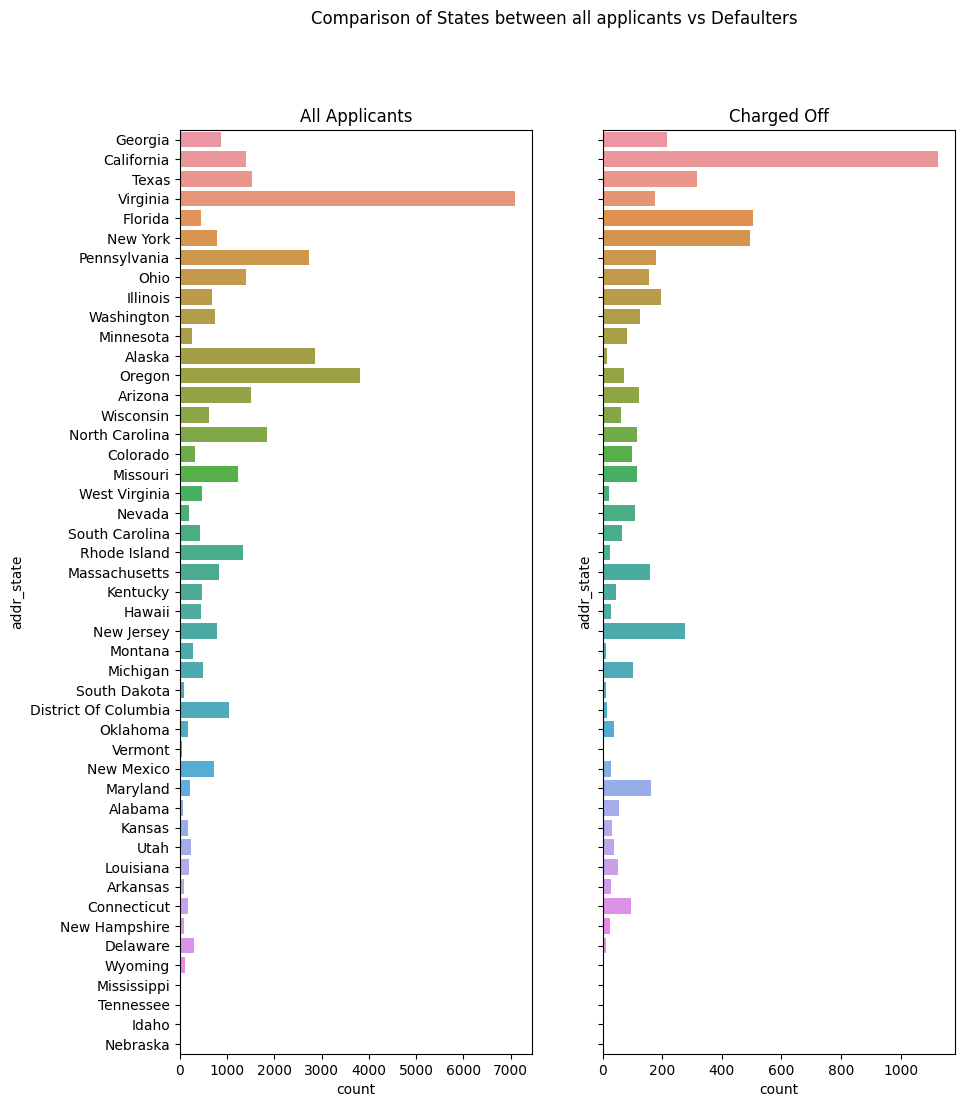

In [52]:
## States
fig, ax = plt.subplots(1,2,figsize = (10,12),sharey=True)
plt.suptitle("Comparison of States between all applicants vs Defaulters")
ax[0].set_title("All Applicants")
sns.countplot(ax=ax[0], y ='addr_state', data=master)

ax[1].set_title("Charged Off")
sns.countplot(ax=ax[1], y ='addr_state', data=charged_off)
plt.show();


### Segmented Univariate Analysis:

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(121)
sns.boxplot(x='term', y=master.loan_amnt, data=master)
plt.title('Terms vs Loan Amount')
plt.subplot(122)
plt.title('Grade vs Loan Amount')
# Finding grades with sorted alphabetical order
grade_ord = master.grade.unique()
grade_ord.sort()
sns.boxplot(x='grade', y=master.loan_amnt, order=grade_ord, data=master)
